# Выбор региона для бурения скважин

**Цель проекта**: построение модели машинного обучения для добывающей компании, которая поможет определить регион, где добыча принесёт наибольшую прибыль.

Механизм выбора локации:
- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Вводные данные от компании**:
- при разведке региона исследуют 500 точек, из которых выбирают 200 лучших для разработки;
- бюджет на разработку скважин в регионе — 10 млрд рублей;
- один баррель сырья приносит 450 рублей дохода (или 450 тыс. руб. с тысячи баррелей);
- вероятность убытков в регионе должна быть меньше 2.5%;
- среди подходящих выберут регион с наибольшей средней прибылью.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Датасет содержит следующие данные:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек;
- product — объём запасов в скважине (тыс. баррелей).

**Основные этапы проекта**:
- Загрузка и подготовка данных
- Обучение и проверка модели для каждого региона
- Подготовка к расчёту прибыли:
    - Определение ключевых констант для расчёта
    - Расчёт достаточного объёма сырья для безубыточной разработки новой скважины
- Написание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели
- Расчёт рисков и наиболее вероятной прибыли для каждого региона методом bootstrap. Выбор региона для разработки.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from scipy import stats as st

Ознакомимся с данными, с которыми предстоит работать:

In [2]:
reg_1 = pd.read_csv('/geo_data_0.csv')
print('Данные о скважинах в Регионе 1:')
display(reg_1.head())
display(reg_1.info())

Данные о скважинах в Регионе 1:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [3]:
print('Данные о скважинах в Регионе 2:')
reg_2 = pd.read_csv('/geo_data_1.csv')
display(reg_2.head())
display(reg_2.info())

Данные о скважинах в Регионе 2:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [4]:
print('Данные о скважинах в Регионе 3:')
reg_3 = pd.read_csv('/geo_data_2.csv')
display(reg_3.head())
display(reg_3.info())

Данные о скважинах в Регионе 3:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Поскольку для анализа каждого региона будет построена отдельная модель, предлагается данные не объединять. Для каждого региона в таблице собраны наблюдения о 100 000 скважин. Пропусков в таблицах нет, типы данных подходят для анализа. Проверим, нет ли дубликатов в ID скважин:

In [5]:
def find_duplicates(data):
    duplicates = data['id'].value_counts()[data['id'].value_counts() >= 2]
    dup_borehole = data.loc[data['id'].isin(duplicates.index)]
    percent = (dup_borehole['product'].sum() / data['product'].sum() * 100).round(2)
    return(dup_borehole, percent)
dubles_1, perc_1 = find_duplicates(reg_1)
print('Доля дублирующих данных о скважинах в общем объеме запасов по Региону 1:', perc_1, '%')
display(dubles_1)

Доля дублирующих данных о скважинах в общем объеме запасов по Региону 1: 0.02 %


,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


In [6]:
dubles_2, perc_2 = find_duplicates(reg_2)
print('Доля дублирующих данных о скважинах в общем объеме запасов по Региону 2:', perc_2, '%')
display(dubles_2)

оля дублирующих данных о скважинах в общем объеме запасов по Региону 2: 0.01 %


,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


In [7]:
dubles_3, perc_3 = find_duplicates(reg_3)
print('Доля дублирующих данных о скважинах в общем объеме запасов по Региону 3:', perc_3, '%')
display(dubles_3)

оля дублирующих данных о скважинах в общем объеме запасов по Региону 3: 0.01 %


,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


В каждом регионе нашлись скважины, записей для которых больше 1. Поскольку у нас нет возможности обратиться к экспертам для пояснения, а объем добычи на таких скважинах относительно всей добычи в регионе невелик и не превышает 0,02%, удалим эти записи. 

Также удалим и столбец с id скважины, поскольку в нём остаются только уникальные значения, которые для построения модели не понадобятся.

И, наконец, для удобства, округлим значения в столбцах до 2-х знаков после разделителя.

In [8]:
# удаляем дубликаты и столбец с id:
reg_1 = reg_1.drop(dubles_1.index).reset_index(drop=True).drop('id', axis = 1).round(2)
reg_1

,f0,f1,f2,product
0,0.71,-0.50,1.22,105.28
1,1.33,-0.34,4.37,73.04
2,1.02,0.15,1.42,85.27
3,-0.03,0.14,2.98,168.62
4,1.99,0.16,4.75,154.04
...,...,...,...,...
99975,0.97,0.37,6.08,110.74
99976,1.39,-0.38,1.27,122.35
99977,1.03,0.02,-1.35,64.38
99978,1.00,-0.53,1.58,74.04


In [9]:
reg_2 = reg_2.drop(dubles_2.index).reset_index(drop=True).drop('id', axis = 1).round(2)
reg_2

,f0,f1,f2,product
0,-15.00,-8.28,-0.01,3.18
1,14.27,-3.48,1.00,26.95
2,6.26,-5.95,5.00,134.77
3,-13.08,-11.51,5.00,137.95
4,12.70,-8.15,5.00,134.77
...,...,...,...,...
99987,9.54,-6.88,2.00,53.91
99988,-10.16,-12.56,5.01,137.95
99989,-7.38,-3.08,5.00,137.95
99990,0.67,-6.15,1.00,30.13


In [10]:
reg_3 = reg_3.drop(dubles_3.index).reset_index(drop=True).drop('id', axis = 1).round(2)
reg_3

,f0,f1,f2,product
0,-1.15,0.96,-0.83,27.76
1,0.26,0.27,-2.53,56.07
2,0.19,0.29,-5.59,62.87
3,2.24,-0.55,0.93,114.57
4,-0.52,1.72,5.90,149.60
...,...,...,...,...
99987,-1.78,1.13,6.26,172.33
99988,-1.26,-0.89,2.52,138.75
99989,-1.20,-2.96,5.22,157.08
99990,-2.42,2.42,-5.55,51.80


Проверим также целевой столбец `products` на аномальные значения:

count    99980.000000
mean        92.499177
std         44.289058
min          0.000000
25%         56.500000
50%         91.850000
75%        128.560000
max        185.360000
Name: product, dtype: float64

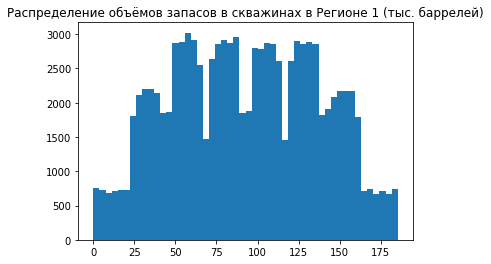

In [11]:
def prod_issue(data, reg_number):
    display(data['product'].describe())
    data['product'].hist(grid=False, bins = 50)
    plt.title('Распределение объёмов запасов в скважинах в Регионе {} (тыс. баррелей)'.format(reg_number))
    plt.show()
prod_issue(reg_1, 1)

count    99992.000000
mean        68.824781
std         45.945679
min          0.000000
25%         26.950000
50%         57.090000
75%        107.810000
max        137.950000
Name: product, dtype: float64

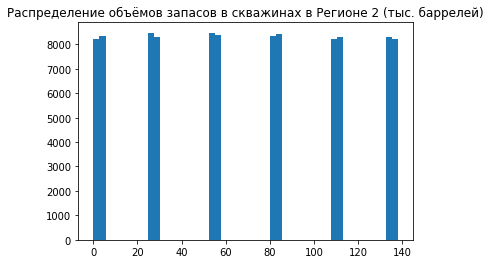

In [12]:
prod_issue(reg_2, 2)

count    99992.000000
mean        94.998778
std         44.747754
min          0.000000
25%         59.450000
50%         94.925000
75%        130.590000
max        190.030000
Name: product, dtype: float64

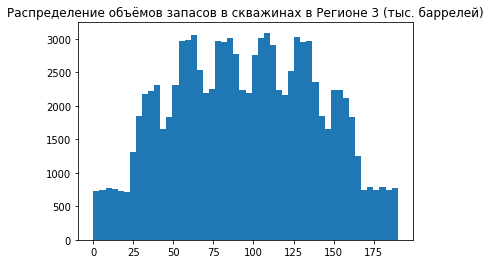

In [13]:
prod_issue(reg_3, 3)

### Вывод
В рамках предобработки выполнено следующее:
- удалена информация о скважинах, для которых было сделано более 1 записи;
- удалён из рассмотрения столбец с id скважины;
- числовые значения округлены до 2 знаков после разделителя.

Данные об объёмах запасов адекватны, отрицательных значений нет, распределения объемов в первом и третьем регионе схожи, по форме напоминают нормальное, однако мультимодальны. Во втором регионе распределение сильно отличается и близко к дискретному равномерному с несколькими значениями объемов.

## Обучение и проверка модели

Для каждого региона разделим выборки на обучающую и валидационную в пропорциях 75/25, построим модель линейной регрессии и рассчитаем RMSE. Для оценки адекватности наших моделей добавим также расчёт RMSE константной модели, которая использует средние значения целевого показателя.

In [14]:
# функция для построения модели:
def regression_model(data):
    # деление на выборки:
    target = data['product']
    features = data.loc[:, 'f0':'f2']
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size = 0.25, random_state = 0)
    
    # обучение и оценка качества модели:
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    RMSE = mean_squared_error(target_valid, predictions_valid)**0.5
    
    # предсказания модели по всем данным:
    predictions = model.predict(features)
    predictions_mean = predictions.mean().round(1)
    
    # константная модель:
    dummy_regr = DummyRegressor(strategy="mean")
    dummy_regr.fit(features_train, target_train)
    dummy_predictions = dummy_regr.predict(features_valid)
    dummy_RMSE = mean_squared_error(target_valid, dummy_predictions)**0.5
    return(predictions_mean, RMSE, dummy_RMSE, predictions, target)

pred_mean_1, RMSE_1, dummy_RMSE_1, predictions_1, target_1 = regression_model(reg_1)
print('Для региона 1', '\n'*2, 'Предсказанный средний объём запасов: {} тыс. баррелей'.format(pred_mean_1),
      '\n', 'RMSE модели: {}'.format(RMSE_1.round(1)), '\n', 'Dummy-RMSE: {}'.format(dummy_RMSE_1.round(1)), sep = '')

Для региона 1

Предсказанный средний объём запасов: 92.5 тыс. баррелей
RMSE модели: 37.5
Dummy-RMSE: 44.3


Покажем распределения фактических запасов и предсказания модели наглядно:

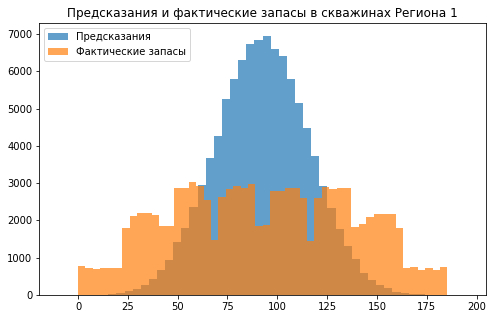

In [15]:
def plots(predictions, target, num):
    plt.figure(figsize=(8, 5))
    plt.hist(predictions, alpha = 0.7, bins = 50, label='Предсказания')
    plt.hist(target, alpha = 0.7, bins = 50, label='Фактические запасы')
    plt.title('Предсказания и фактические запасы в скважинах Региона {}'.format(num))
    plt.legend(loc = 'upper left')
    plt.show()
plots(predictions_1, target_1, 1)

Для региона 2

Предсказанный средний объём запасов: 68.8 тыс. баррелей
RMSE модели: 0.9
Dummy-RMSE: 46.0


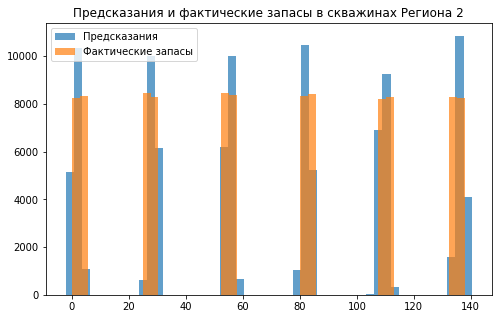

In [16]:
pred_mean_2, RMSE_2, dummy_RMSE_2, predictions_2, target_2 = regression_model(reg_2)
print('Для региона 2', '\n'*2, 'Предсказанный средний объём запасов: {} тыс. баррелей'.format(pred_mean_2),
      '\n', 'RMSE модели: {}'.format(RMSE_2.round(1)), '\n', 'Dummy-RMSE: {}'.format(dummy_RMSE_2.round(1)), sep = '')
plots(predictions_2, target_2, 2)

Для региона 3

Предсказанный средний объём запасов: 95.0 тыс. баррелей
RMSE модели: 40.0
Dummy-RMSE: 44.6


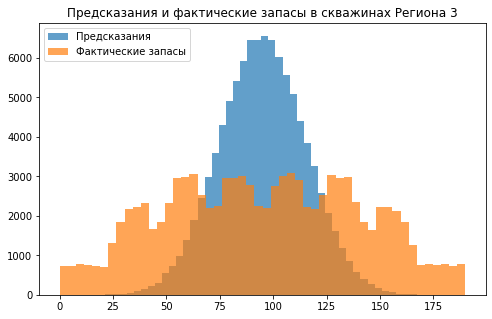

In [17]:
pred_mean_3, RMSE_3, dummy_RMSE_3, predictions_3, target_3 = regression_model(reg_3)
print('Для региона 3', '\n'*2, 'Предсказанный средний объём запасов: {} тыс. баррелей'.format(pred_mean_3),
      '\n', 'RMSE модели: {}'.format(RMSE_3.round(1)), '\n', 'Dummy-RMSE: {}'.format(dummy_RMSE_3.round(1)), sep = '')
plots(predictions_3, target_3, 3)

Объединим результаты в таблицу:

In [18]:
result_table = pd.DataFrame([[pred_mean_1, pred_mean_2, pred_mean_3], [RMSE_1, RMSE_2, RMSE_3]], 
                            columns=['Регион 1', 'Регион 2', 'Регион 3'],
index = ['Средние запасы', 'RMSE'])
result_table.round(2)

,Регион 1,Регион 2,Регион 3
Средние запасы,92.5,68.80,95.00
RMSE,37.5,0.89,40.04


### Вывод
Построенные модели регрессии для всех регионов показывают ошибку RMSE меньше, чем константные модели. Самая маленькая ошибка - у модели для второго региона, вероятно, за счёт характера распределения запасов в этом регионе. Максимальная ошибка - у модели для третьего региона, она ненамного ниже, чем у константной модели, и составляет 42% от среднего значения целевой переменной, что на мой взгляд, достаточно много. 

Наибольший объем запасов предсказывается в Регионе 3 - 95 тыс. баррелей., минимальный - в Регионе 2 - 68,8 тыс. баррелей.

## Подготовка к расчёту прибыли

Все ключевые значения для расчётов сохраним в отдельных переменных. Все денежные показатели будем указывать в тысячах рублей:
- `BUDGET` - общий бюджет на разработку скважин в регионе (10 млрд. руб.)
- `INCOME_PER_TH_BARREL` - доход с каждой тысячи баррелей (450 тыс. руб.)
- `NUM_FOR_EXPLORE` - количество скважин, которое исследуется в каждом регионе (500)
- `NUM_BEST_BORE` - количество лучших скважин, которое будет разработано в каждом регионе (200)

Средние запасы для каждого региона уже сохранены на предыдущем шаге.

In [19]:
BUDGET = 10000000
INCOME_PER_TH_BARREL = 450 
NUM_FOR_EXPLORE = 500
NUM_BEST_BORE = 200

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины (учитываем, что в каждом регионе будет разработано по 200 скважин):

In [20]:
min_value = (BUDGET/INCOME_PER_TH_BARREL)/200
print('Минимальный средний объем запасов в скважине: {} тыс. баррелей'.format(round(min_value, 2)))

Минимальный средний объем запасов в скважине: 111.11 тыс. баррелей


Ни в одном из исследуемых регионов средний объём предсказанных запасов не удовлетворяет условию безубыточности. Но нужно учитывать, что среднее рассчитано по всем предсказанным скважинам. На следующем этапе отберём самые прибыльные скважины, и посчитаем прогнозную прибыль для них.

Напишем функцию, которая будет отбирать 200 скважин с максимальным значением предсказанных запасов, считать фактический объём запасов в них и ожидаемую прибыль от их разработки:

In [21]:
def best_bore(target, predictions):
    predictions = pd.Series(predictions)
    target = pd.Series(target).reset_index(drop=True)
    pred_sort = predictions.sort_values(ascending = False)
    selected_bore = target[pred_sort.index][:NUM_BEST_BORE]
    total_profit = sum(selected_bore)*INCOME_PER_TH_BARREL - BUDGET
    return(total_profit)
print('Ожидаемая прибыль от 200 лучших скважин в Регионе 1: {} млрд. руб.'.format(
    round(best_bore(target_1, predictions_1)/1000000, 2)))

Ожидаемая прибыль от 200 лучших скважин в Регионе 1: 3.49 млрд. руб.


In [22]:
print('Ожидаемая прибыль от 200 лучших скважин в Регионе 2: {} млрд. руб.'.format(
    round(best_bore(target_2, predictions_2)/1000000, 2)))

Ожидаемая прибыль от 200 лучших скважин в Регионе 2: 2.42 млрд. руб.


In [23]:
print('Ожидаемая прибыль от 200 лучших скважин в Регионе 3: {} млрд. руб.'.format(
    round(best_bore(target_3, predictions_3)/1000000, 2)))

Ожидаемая прибыль от 200 лучших скважин в Регионе 3: 2.58 млрд. руб.


### Вывод
Данные подготовлены для анализа прибыли и рисков. 

Во всех трёх регионах ожидаемая прибыль от разработки 200 лучших по результатам работы модели скважин положительна.

## Расчёт прибыли и рисков 

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли для каждого региона:

In [24]:
state = np.random.RandomState(1)
def bootstrap(target, predictions):
    profits = []
    for i in range(1000):
        target_subsample = target.sample(n = NUM_FOR_EXPLORE, replace = True, random_state = state)
        predictions_subsample = predictions[target_subsample.index]
        
        # расчёт прибыли:
        profits.append(best_bore(target_subsample, predictions_subsample))
    profits = pd.Series(profits)
    mean_profit = profits.mean()
    
    # расчёт вероятности убытка:
    p_loss = (profits < 0).mean()*100
    
    # расчёт доверительных интервалов:
    q_lower = round(profits.quantile(0.025)/1000000, 2)
    q_upper = round(profits.quantile(0.975)/1000000, 2)
    return(profits, mean_profit, p_loss, q_lower, q_upper)
    
profits_1, mean_profit_1, p_loss_1, q_lower_1, q_upper_1 = bootstrap(target_1, predictions_1)
print('Для Региона 1:', '\n'*2, 'Ожидаемая средняя прибыль равна {} млрд. руб.'.format(round(mean_profit_1/1000000, 2)),
     '\n', '95%-ый доверительный интервал для прибыли: (', q_lower_1, ', ', q_upper_1, ') млрд. руб.',
     '\n', 'Вероятность убытка составляет {}%'.format(p_loss_1),  sep = '')

Для Региона 1:

Ожидаемая средняя прибыль равна 0.42 млрд. руб.
95%-ый доверительный интервал для прибыли: (-0.08, 0.9) млрд. руб.
Вероятность убытка составляет 5.3%


In [25]:
profits_2, mean_profit_2, p_loss_2, q_lower_2, q_upper_2 = bootstrap(target_2, predictions_2)
print('Для Региона 2:', '\n'*2, 'Ожидаемая средняя прибыль равна {} млрд. руб.'.format(round(mean_profit_2/1000000, 2)),
     '\n', '95%-ый доверительный интервал для прибыли: (', q_lower_2, ', ', q_upper_2, ') млрд. руб.',
     '\n', 'Вероятность убытка составляет {}%'.format(round(p_loss_2, 2)),  sep = '')

Для Региона 2:

Ожидаемая средняя прибыль равна 0.46 млрд. руб.
95%-ый доверительный интервал для прибыли: (0.07, 0.86) млрд. руб.
Вероятность убытка составляет 1.1%


In [26]:
profits_3, mean_profit_3, p_loss_3, q_lower_3, q_upper_3 = bootstrap(target_3, predictions_3)
print('Для Региона 3:', '\n'*2, 'Ожидаемая средняя прибыль равна {} млрд. руб.'.format(round(mean_profit_3/1000000, 2)),
     '\n', '95%-ый доверительный интервал для прибыли: (', q_lower_3, ', ', q_upper_3, ') млрд. руб.',
     '\n', 'Вероятность убытка составляет {}%'.format(p_loss_3),  sep = '')

Для Региона 3:

Ожидаемая средняя прибыль равна 0.38 млрд. руб.
95%-ый доверительный интервал для прибыли: (-0.15, 0.94) млрд. руб.
Вероятность убытка составляет 8.6%


In [29]:
total_table = pd.DataFrame([[mean_profit_1/1000, mean_profit_2/1000, mean_profit_3/1000], [p_loss_1, p_loss_2, p_loss_3]], 
                            columns=['Регион 1', 'Регион 2', 'Регион 3'],
index = ['Прогнозная прибыль, млн. руб.', 'Вероятность убытков, %'])
total_table.round(2)

,Регион 1,Регион 2,Регион 3
"Прогнозная прибыль, млн. руб.",417.41,455.99,376.0
"Вероятность убытков, %",5.30,1.10,8.6


# Вывод
Перед нами была поставлена задача построения модели машинного обучения для добывающей компании, которая поможет определить регион, где добыча принесёт наибольшую прибыль при затратах на разработку в 10 млрд. руб., приемлемом риске убытков - не более 2,5%. В качестве модели для анализа использовалась линейная регрессия. Для всех регионов построенные модели оказались адекватны, лучшего качества с применением метрики RMSE удалось достичь модели для Региона 2.

С помощью метода bootstrap смоделированы вероятные значения прибыли в каждом регионе, рассчитан риск получения убытка от разработки. 

Из трёх рассмотренных регионов только один удовлетворяет условию заказчика относительно рисков убытков, которые не должны превышать 2,5%: Регион 2. Прогнозные показатели региона:
- средняя прибыль от разработки 200 лучших скважин в регионе составит 442 млн. руб. 
- вероятность убытков составляет 1,1% 
- с вероятностью 95% прибыль от разработки Региона 2 будет лежать в промежутке от 70 до 860 млн. руб.

**Добывающей компании в качестве региона для разработки рекомендуется выбрать Регион №2**.